# Training SSD300
In this tutorial, we will show how to initialize, train and test SSD300 for object detection.
The tutorial is based on a subset of pictures from the PascalVOC dataset (both 2007 and 2012), but can be generalized to be used with the whole PascalVOC or other custom/benchmark datasets.

### Imports
We start by importing all the necessary functions.

In [1]:
import torch
from PIL import Image
from time import time
import numpy as np
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms

import sys
sys.path.insert(0, '/scratch/lmeneghe/Smithers/')

from smithers.ml.models.vgg import VGG
from smithers.ml.models.aux_conv import AuxiliaryConvolutions
from smithers.ml.models.predictor import PredictionConvolutions
from smithers.ml.dataset.pascalvoc_dataset import PascalVOCDataset
from smithers.ml.models.detector import Detector
from smithers.ml.models.utils_objdet import create_prior_boxes


import warnings
warnings.filterwarnings("ignore")

### Parameters Initialization
We set the parameters used for the data, the detector and the learning phase.

In [2]:
# Learning parameters
batch_size = 8  # batch size
workers = 4  # number of workers for loading data in the DataLoader
iterations = 120000  # number of iterations to train
print_freq = 200  # print training status every __ batches
lr = 1e-4  # learning rate
decay_lr_at = [80000, 100000]  # decay learning rate after these many iterations
decay_lr_to = 0.1
# decay learning rate to this fraction of the existing learning rate
#n_classes = 6
momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
grad_clip = None
# clip if gradients are exploding, which may happen at larger batch sizes

### Dataset Loading
We need to load and create the datasets for training and testing our model. In this case we are using a dataset extracted from PascalVOC that has been created using ***smithers/ml/dataset/sample_dataset.py***. For more details about this, refer to the tutorial ***pascalvoc_preparation***, which explains also how to use the whole PascalVOC dataset. Instead, to use a custom dataset for this purpose, refer to the turial ***customdata_objdet***.

In [3]:
#voc_labels = ('aeroplane', 'bicycle', 'bird', 'boat',
#        'bottle', 'bus', 'car', 'cat', 'chair',
#        'cow', 'diningtable', 'dog', 'horse',
#        'motorbike', 'person', 'pottedplant',
#        'sheep', 'sofa', 'train', 'tvmonitor')
voc_labels = ('cat', 'dog')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map['background'] = 0
n_classes = len(label_map)
print('categories:',label_map)
print('n_classes:', n_classes)

# Data parameters
data_folder = 'VOC_dog_cat/JSONfiles' #folder with json data files
keep_difficult = True


train_dataset = PascalVOCDataset(data_folder,
                                 split='train',
                                 keep_difficult=keep_difficult)
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=train_dataset.collate_fn,
    num_workers=workers,
    pin_memory=True)

epochs = iterations // (len(train_dataset) // 16) #500
decay_lr_at = [it // (len(train_dataset) // 16) for it in decay_lr_at]
print('Training images:', len(train_dataset))


test_dataset = PascalVOCDataset(data_folder,
                                split='test',
                                keep_difficult=keep_difficult)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=test_dataset.collate_fn,
                                          num_workers=workers,
                                          pin_memory=True)
print('Testing images:', len(test_dataset))


categories: {'cat': 1, 'dog': 2, 'background': 0}
n_classes: 3
Training images: 240
Testing images: 60


### Creation and loading of the SSD300 model
We are now going to initialize SSD300 using the class ***Detector*** of ***smithers/ml/models/detector.py***, based on the original paper: 

'SSD: Single Shot Multibox Detector' by Wei Liu, Dragomir Anguelov, Dumitru Erhan, Christian Szegedy, Scott Reed, Cheng-Yang Fu, Alexander C. Berg https://arxiv.org/abs/1512.02325 ,DOI: 10.1007/978-3-319-46448-0_2

In this case, we should select 'ssd' as classifier for VGG in order to substitute the feedforward classification layers of the original VGG with convolutional layers. We have then initialized SSD300 using pre-trained wegiths on ImageNet (a common choice in this field).


In [4]:
start_init = time()
base_net = VGG(classifier='ssd', init_weights='imagenet')
aux_conv = AuxiliaryConvolutions()
predictor = PredictionConvolutions(n_classes)
network = [base_net, aux_conv, predictor]
priors_cxcy = create_prior_boxes()
end_init = time()
print('Time needed to initialize the net: {} seconds'.format(round(end_init-start_init,2)))


Loaded base model.

Time needed to initialize the net: 2.58 seconds


### Training Phase
Once we have created and initliazed the network we can train it.


Here, the network will trained and, if provided, a checkpoint can be used to start from an already trained network.

The training procedure will store a checkpoint file named ``checkpoint_ssd300.pth.tar``, once it is completed.
Furthermore, the plot of the value of the loss against the corresponding epoch is produced.

In [5]:
check = None # if no checkpoint available
#check = 'checkpoint_ssd300.pth.tar' #if a checkpoint is available
epochs = 60
start = time()
detector = Detector(network, check, priors_cxcy, n_classes, epochs,
                        batch_size, print_freq, lr, decay_lr_at,
                        decay_lr_to, momentum, weight_decay, grad_clip,
                        train_loader, test_loader, 'Adam')
print(detector.model)
checkpoint, loss_values = detector.train_detector()
end = time()
print(f'Time needed for training the net: {round(end-start,2)} seconds, i.e. {round((end-start)/60,1)} minutes')

[VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

Epoch: [45][0/30]	Batch Time 0.508 (0.508)	Data Time 0.294 (0.294)	Loss val (average) 3.0490 (3.0490)	
Epoch: [46][0/30]	Batch Time 0.495 (0.495)	Data Time 0.281 (0.281)	Loss val (average) 2.6906 (2.6906)	
Epoch: [47][0/30]	Batch Time 0.422 (0.422)	Data Time 0.206 (0.206)	Loss val (average) 2.9869 (2.9869)	
Epoch: [48][0/30]	Batch Time 0.501 (0.501)	Data Time 0.287 (0.287)	Loss val (average) 3.2848 (3.2848)	
Epoch: [49][0/30]	Batch Time 0.431 (0.431)	Data Time 0.217 (0.217)	Loss val (average) 2.5937 (2.5937)	
Epoch: [50][0/30]	Batch Time 0.494 (0.494)	Data Time 0.276 (0.276)	Loss val (average) 2.8005 (2.8005)	
Epoch: [51][0/30]	Batch Time 0.534 (0.534)	Data Time 0.323 (0.323)	Loss val (average) 3.4860 (3.4860)	
Epoch: [52][0/30]	Batch Time 0.463 (0.463)	Data Time 0.248 (0.248)	Loss val (average) 2.7057 (2.7057)	
Epoch: [53][0/30]	Batch Time 0.496 (0.496)	Data Time 0.285 (0.285)	Loss val (average) 2.9458 (2.9458)	
Epoch: [54][0/30]	Batch Time 0.495 (0.495)	Data Time 0.280 (0.280)	Loss v

### Loss function
In order to understand if the training phase was completed in an optimal way, we can plot the loss function in order to show its behavior over time.

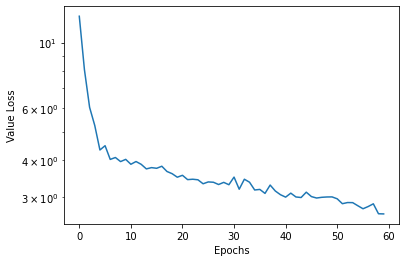

In [6]:
n_epochs = np.arange(start=0, stop=epochs, step=1)
plt.plot(n_epochs, loss_values)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Value Loss')
plt.savefig('loss_function.png')

### Testing Phase
Once we have a trained model, we can analyze its accuracy against the testing dataset using the method ***eval_detector*** implemented in the class ***Detector***. It provides in output the accuracy for each class composing the dataset and the Mean Average Precision (mAP), which represents the mean of the precisions over the different categories under consideration.

In [7]:
start_test = time()
detector.eval_detector(label_map)
end_test = time()

print(f'Time needed for testing the net: {round(end_test-start_test,2)} seconds, i.e. {round((end_test-start_test)/60,1)} minutes')

Evaluating: 100%|██████████| 8/8 [00:03<00:00,  2.52it/s]


{'cat': 71.9229519367218, 'dog': 49.422404170036316}
{'cat': 71.9229519367218, 'dog': 49.422404170036316}

Mean Average Precision (mAP): 60.673
Time needed for testing the net: 3.39 seconds, i.e. 0.1 minutes


### Image Detection
By choosing a specific image from the directory used, the network is able to detect the object(s) in it and save a version of the image in which the bounding box(es) with the relative label(s) is(/are) pictured. To view this, open the file ``out.jpg``, as described below.

In [8]:
img_path = 'VOC_dog_cat/JPEGImages/001825.jpg'
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')

detector.detect(original_image,
                label_map,
                min_score=0.01,
                max_overlap=0.45,
                top_k=1).show()

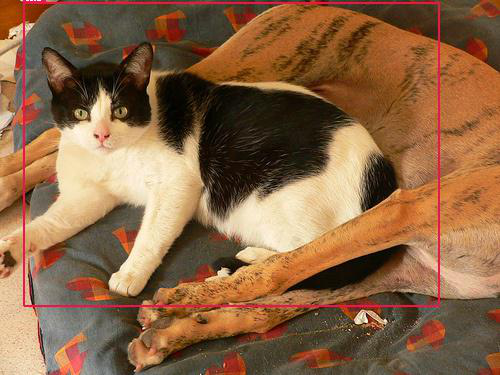

In [9]:
out_img = Image.open('out.jpg')
display(out_img)